# Assessment Task

Using the Boston data set introduced during LAB work, apply linear regression modelling to predict the per capita crime rate using other variables in the data set. In other words, per capita crime rate is the response and the other variables are predictors.


a) Use descriptive statistics to explore the dataset.


In [73]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Reorder colour palette
def_palette = sns.color_palette('deep')
reordered_palette = [def_palette[i] for i in [9, 1, 2, 3, 4, 5, 6, 7, 8, 0]]
sns.set_palette(reordered_palette)


In [81]:
# Callable function to create plots
def multi_row_plot(
    seaborn_func: object,
    data: object,
    grid: tuple = (4, 4),
    size: tuple = (25, 20),
) -> None:
    """Create a plot with default values.

    Args:
        seaborn_func (object): seaborn plot function to run.
        data (object): _description_
        grid (tuple, optional): Rows and columns. Defaults to (2, 7).
        size (tuple, optional): Width and Height. Defaults to (32, 7).

    """
    data_cols = data.columns

    # Structure plots to easily fit the data.
    fig_plot, axes = plt.subplots(grid[0], grid[1], figsize=(size[0], size[1]))
    # Flatten axes so it is easier to enumerate.
    axes = axes.flatten()

    for i, item in enumerate(data_cols):
        seaborn_func(data=data, x=item, ax=axes[i])

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')


def find_outliers(data, column):
    quart1 = data[column].quantile(0.25)
    quart3 = data[column].quantile(0.75)
    inter_quart = quart3 - quart1
    lower_bound = quart1 - 1.5 * inter_quart
    upper_bound = quart3 + 1.5 * inter_quart
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)][
        column
    ]


def winsorize_outliers(data_orig, data_win, col):
    outliers = find_outliers(data_orig, col)
    if not outliers.empty:
        quart1 = data_orig[col].quantile(0.25)
        quart3 = data_orig[col].quantile(0.75)
        inter_quart = quart3 - quart1
        lower_bound = quart1 - 1.5 * inter_quart
        upper_bound = quart3 + 1.5 * inter_quart

        # Only clip the outliers
        data_win[col] = np.where(
            data_orig[col] < lower_bound,
            lower_bound,
            np.where(
                data_orig[col] > upper_bound, upper_bound, data_orig[col]
            ),
        )


# def winsorize_data(orig_data, copy_data, col_name):
#     lower_bound = orig_data[col_name].quantile(0.05)
#     upper_bound = orig_data[col_name].quantile(0.95)
#     copy_data[col_name] = orig_data[col_name].clip(
#         lower=lower_bound, upper=upper_bound
#     )


In [55]:
# Access CSV file
boston_csv = pd.read_csv('boston-data.csv')

In [56]:
boston_csv.isna().sum()

CRIM     0
ZN       0
INDUS    0
CHAS     0
NOX      0
RM       0
AGE      0
DIS      0
RAD      0
TAX      0
PT       0
B        0
LSTAT    0
MV       0
dtype: int64

In [57]:
# Display and read data info and type.
boston_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CRIM    506 non-null    float64
 1   ZN      506 non-null    float64
 2   INDUS   506 non-null    float64
 3   CHAS    506 non-null    int64  
 4   NOX     506 non-null    float64
 5   RM      506 non-null    float64
 6   AGE     506 non-null    float64
 7   DIS     506 non-null    float64
 8   RAD     506 non-null    int64  
 9   TAX     506 non-null    int64  
 10  PT      506 non-null    float64
 11  B       506 non-null    float64
 12  LSTAT   506 non-null    float64
 13  MV      506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


In [58]:
# Use describe to view summary statistics for each variable.
boston_csv.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PT,B,LSTAT,MV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674030,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148862,2.105710,8.707259,168.537116,2.164946,91.294863,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377487,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440002,11.360000,21.200001
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.074999,5.188425,24.000000,666.000000,20.200001,396.225006,16.954999,25.000000
max,88.976196,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.899994,37.970001,50.000000


Add box plots to identify outliers.


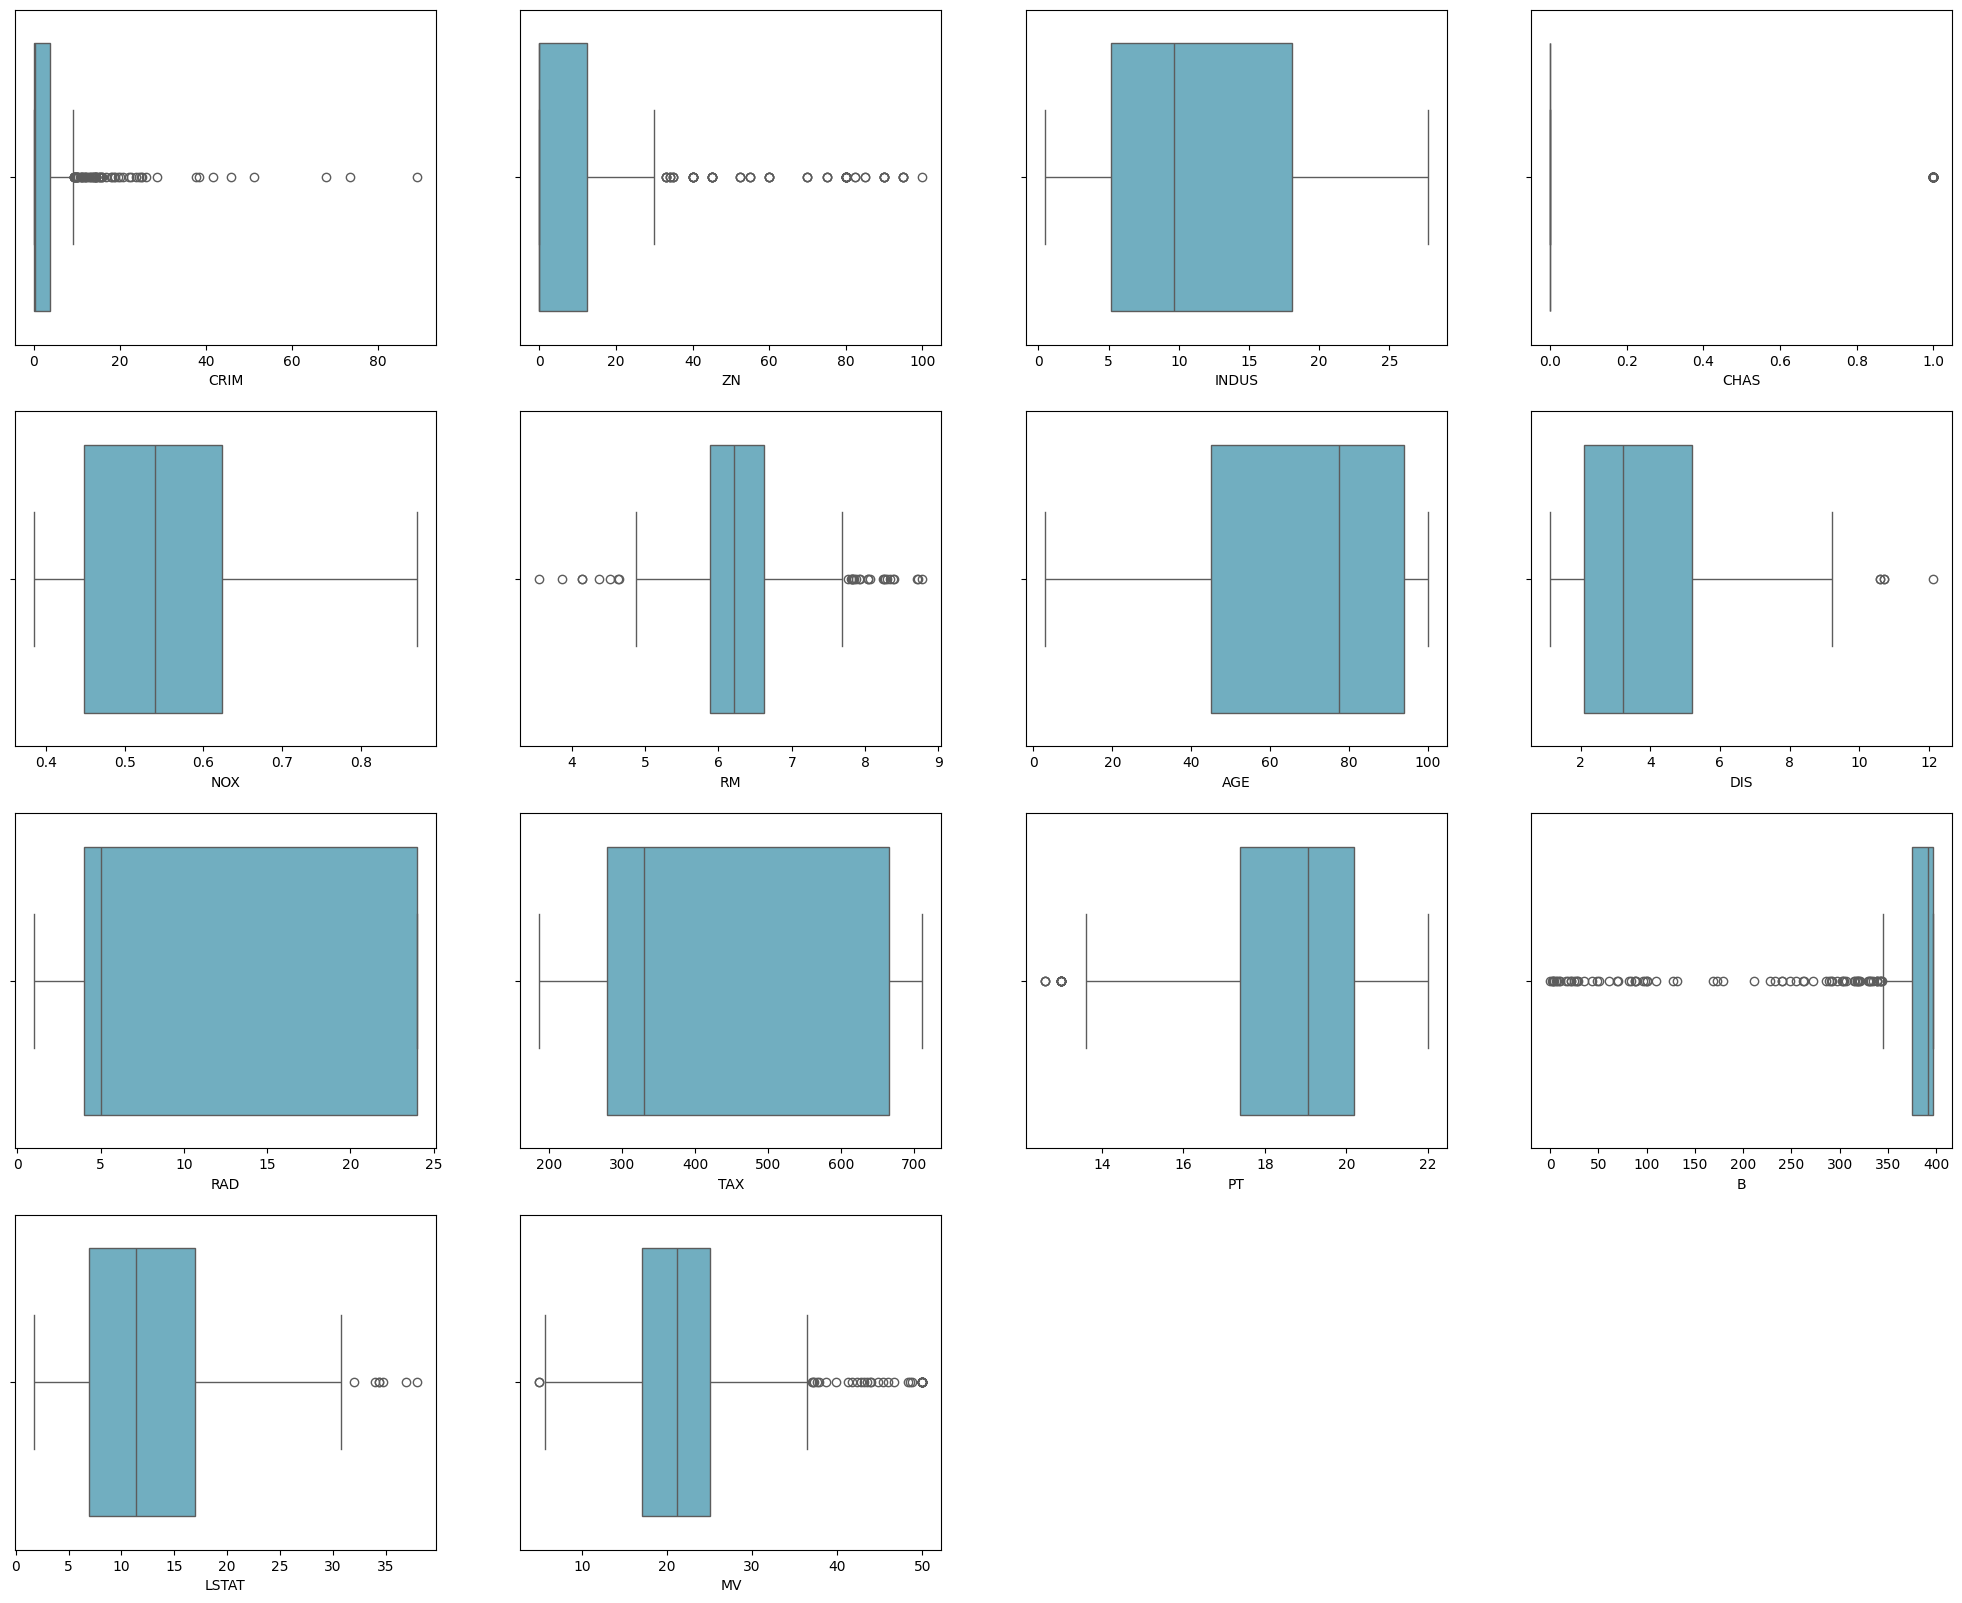

In [59]:
# Structure plots to easily fit the data.
multi_row_plot(sns.boxplot, boston_csv)


Clean outliers from relevant data.

In [70]:
# Example of data output by find_outliers
find_outliers(boston_csv, "CRIM")

367    13.522200
371     9.232300
373    11.108100
374    18.498199
375    19.609100
         ...    
468    15.575700
469    13.075100
477    15.023400
478    10.233000
479    14.333700
Name: CRIM, Length: 66, dtype: float64

In [82]:
# Winsorize the data
boston_win = boston_csv.copy(deep=True)

for i, col in enumerate(boston_csv.columns):
    # Skip CHAR column
    if i == 3:
        continue
    winsorize_outliers(boston_csv, boston_win, col)

boston_win.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PT,B,LSTAT,MV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,2.225032,6.963439,11.136779,0.069170,0.554695,6.275312,68.574901,3.783947,9.549407,408.237154,18.463834,381.918828,12.612011,21.877075
std,3.313353,12.028788,6.860353,0.253994,0.115878,0.630242,28.148862,2.069765,8.707259,168.537116,2.143925,19.054924,7.016829,7.602976
min,0.006320,0.000000,0.460000,0.000000,0.385000,4.778500,2.900000,1.129600,1.000000,187.000000,13.199998,344.106209,1.730000,5.062500
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377487,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440002,11.360000,21.200001
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.074999,5.188425,24.000000,666.000000,20.200001,396.225006,16.954999,25.000000
max,9.069639,31.250000,27.740000,1.000000,0.871000,7.730500,100.000000,9.820801,24.000000,711.000000,22.000000,396.899994,31.962499,36.962500


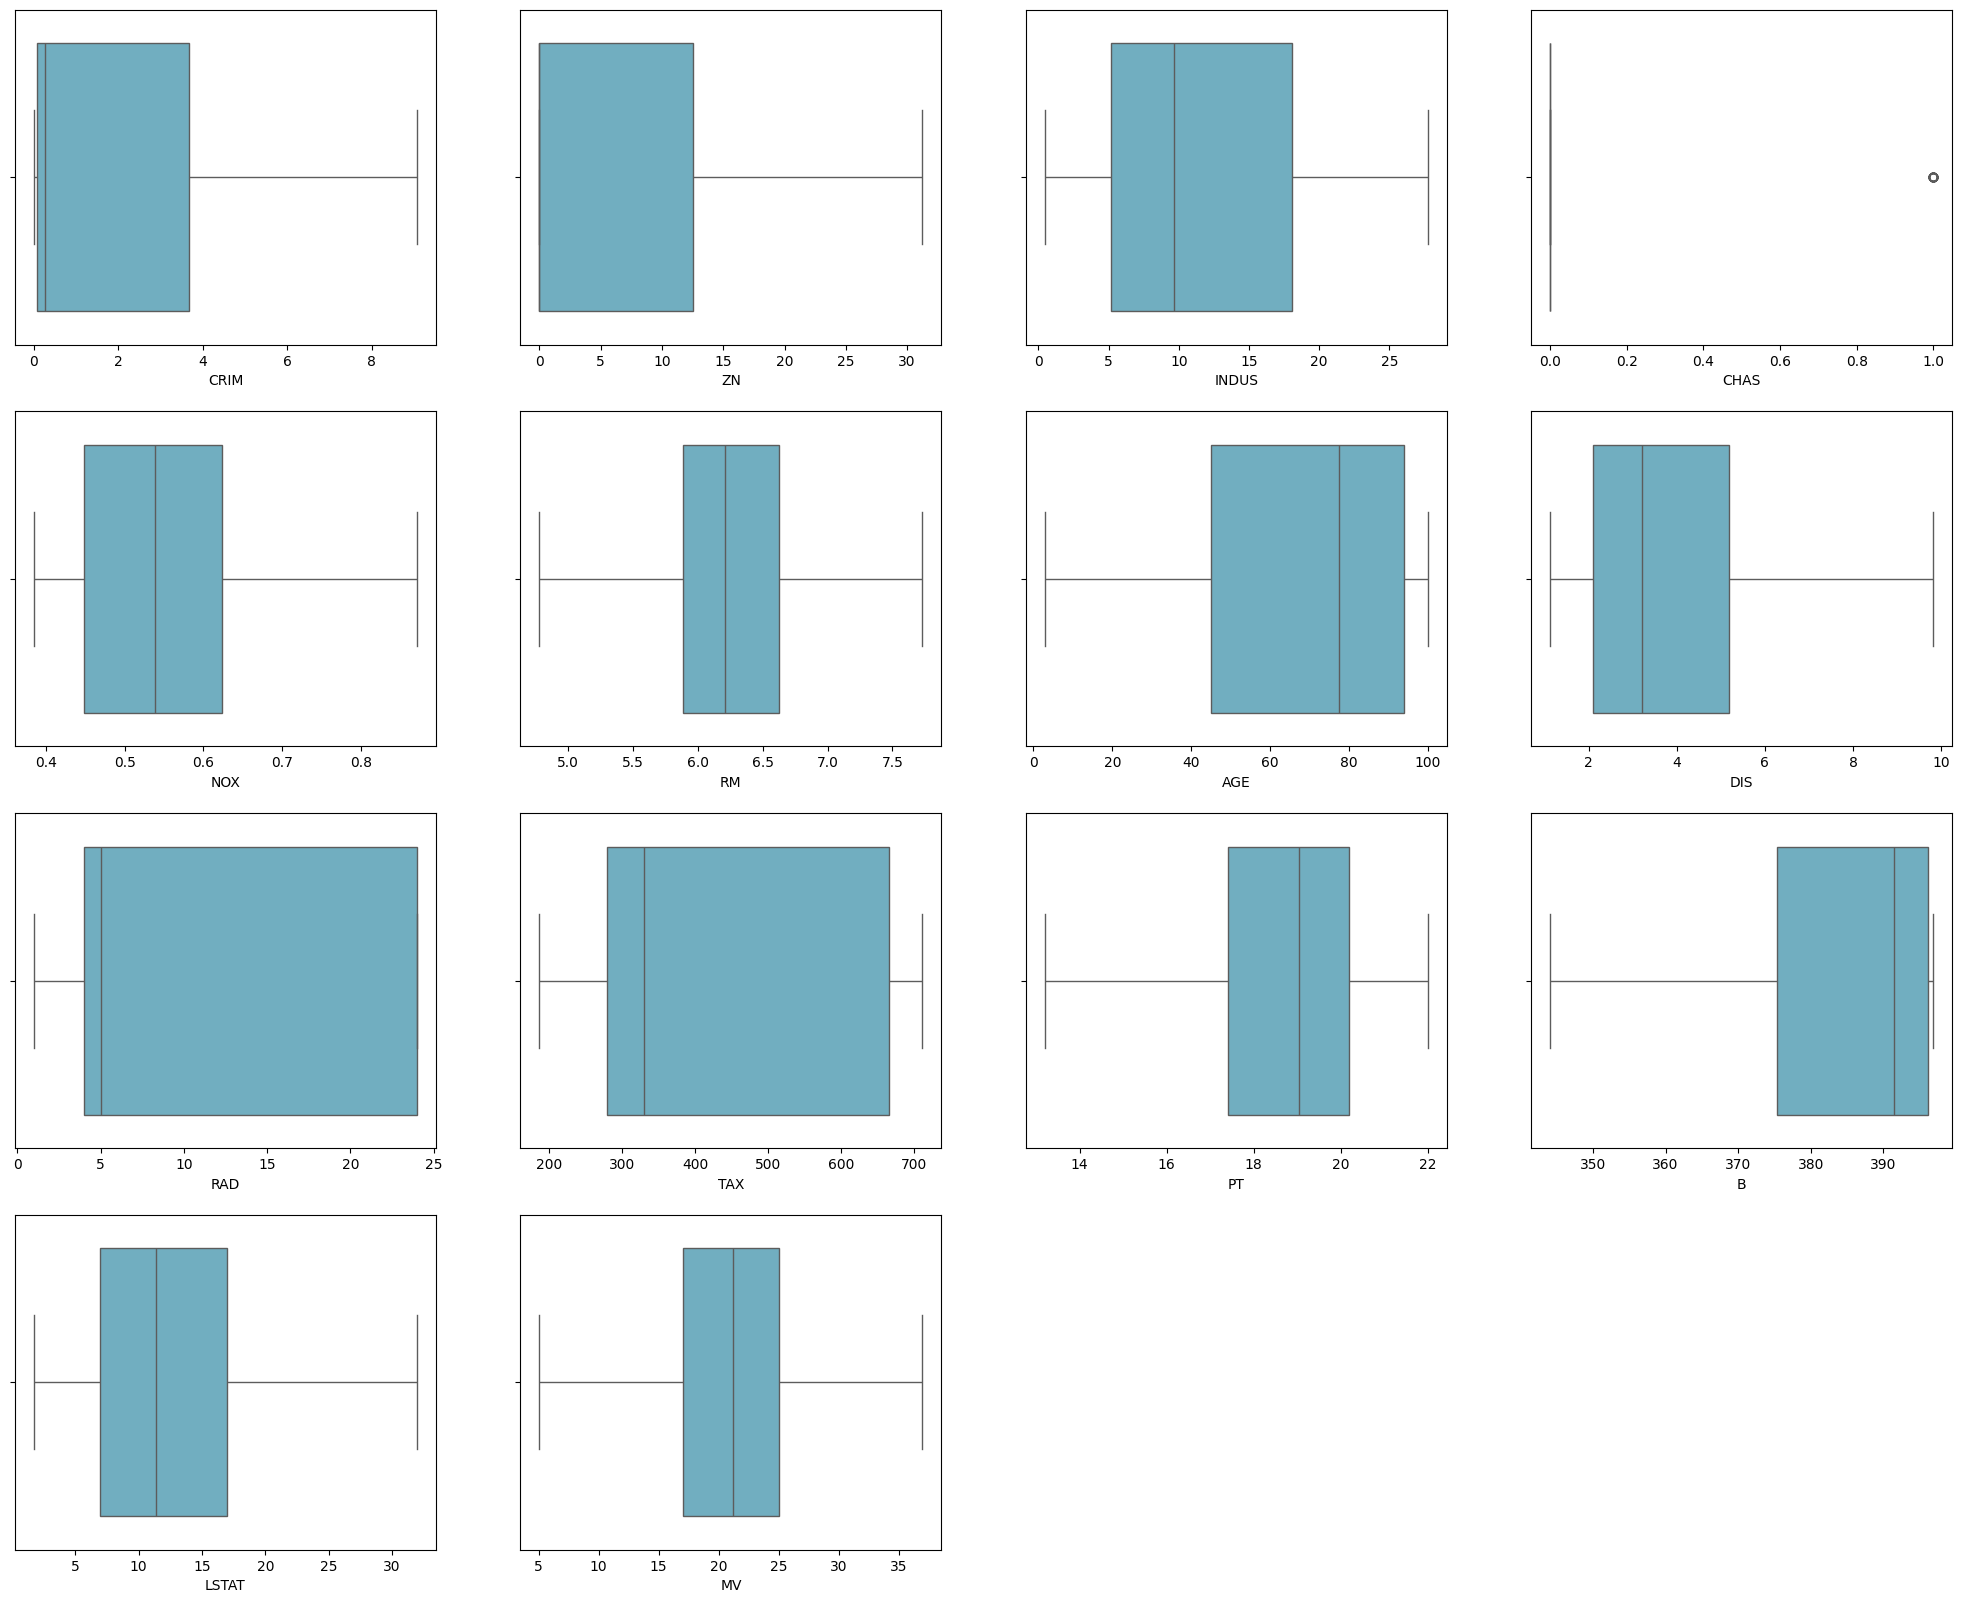

In [83]:
multi_row_plot(sns.boxplot,boston_win)

Plot histograms to see the distribution of the data.


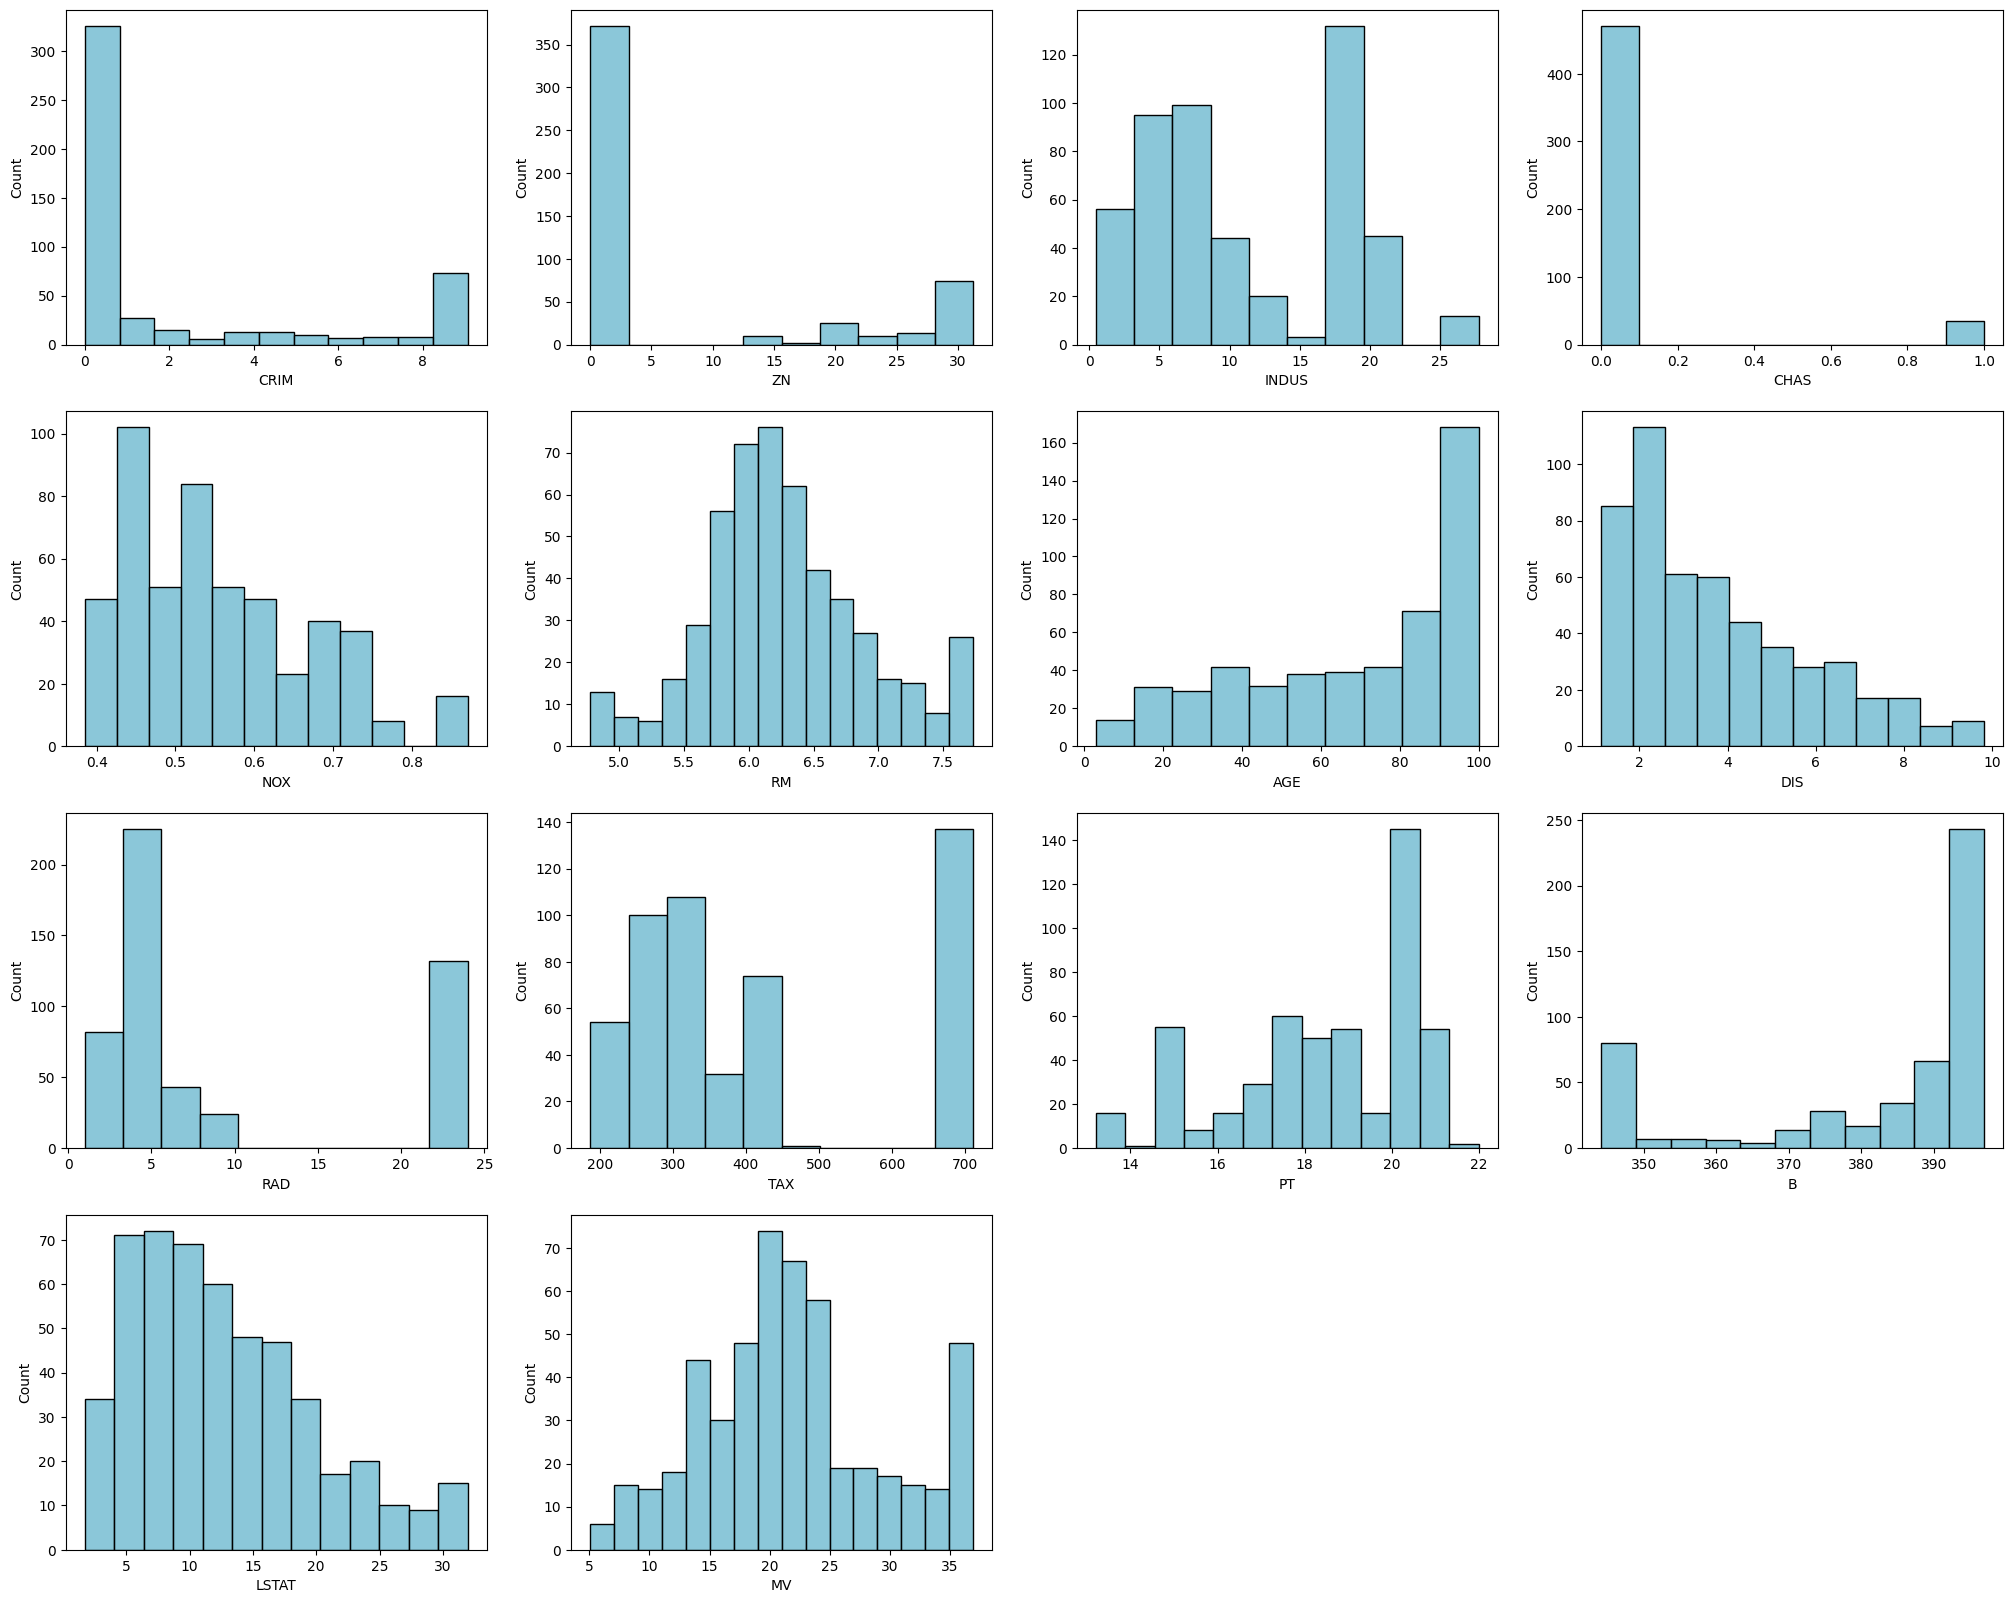

In [84]:
# Structure plots to easily fit the data.
multi_row_plot(sns.histplot, boston_win)

Add violin plots to show median, interquartile range, concentration of values.


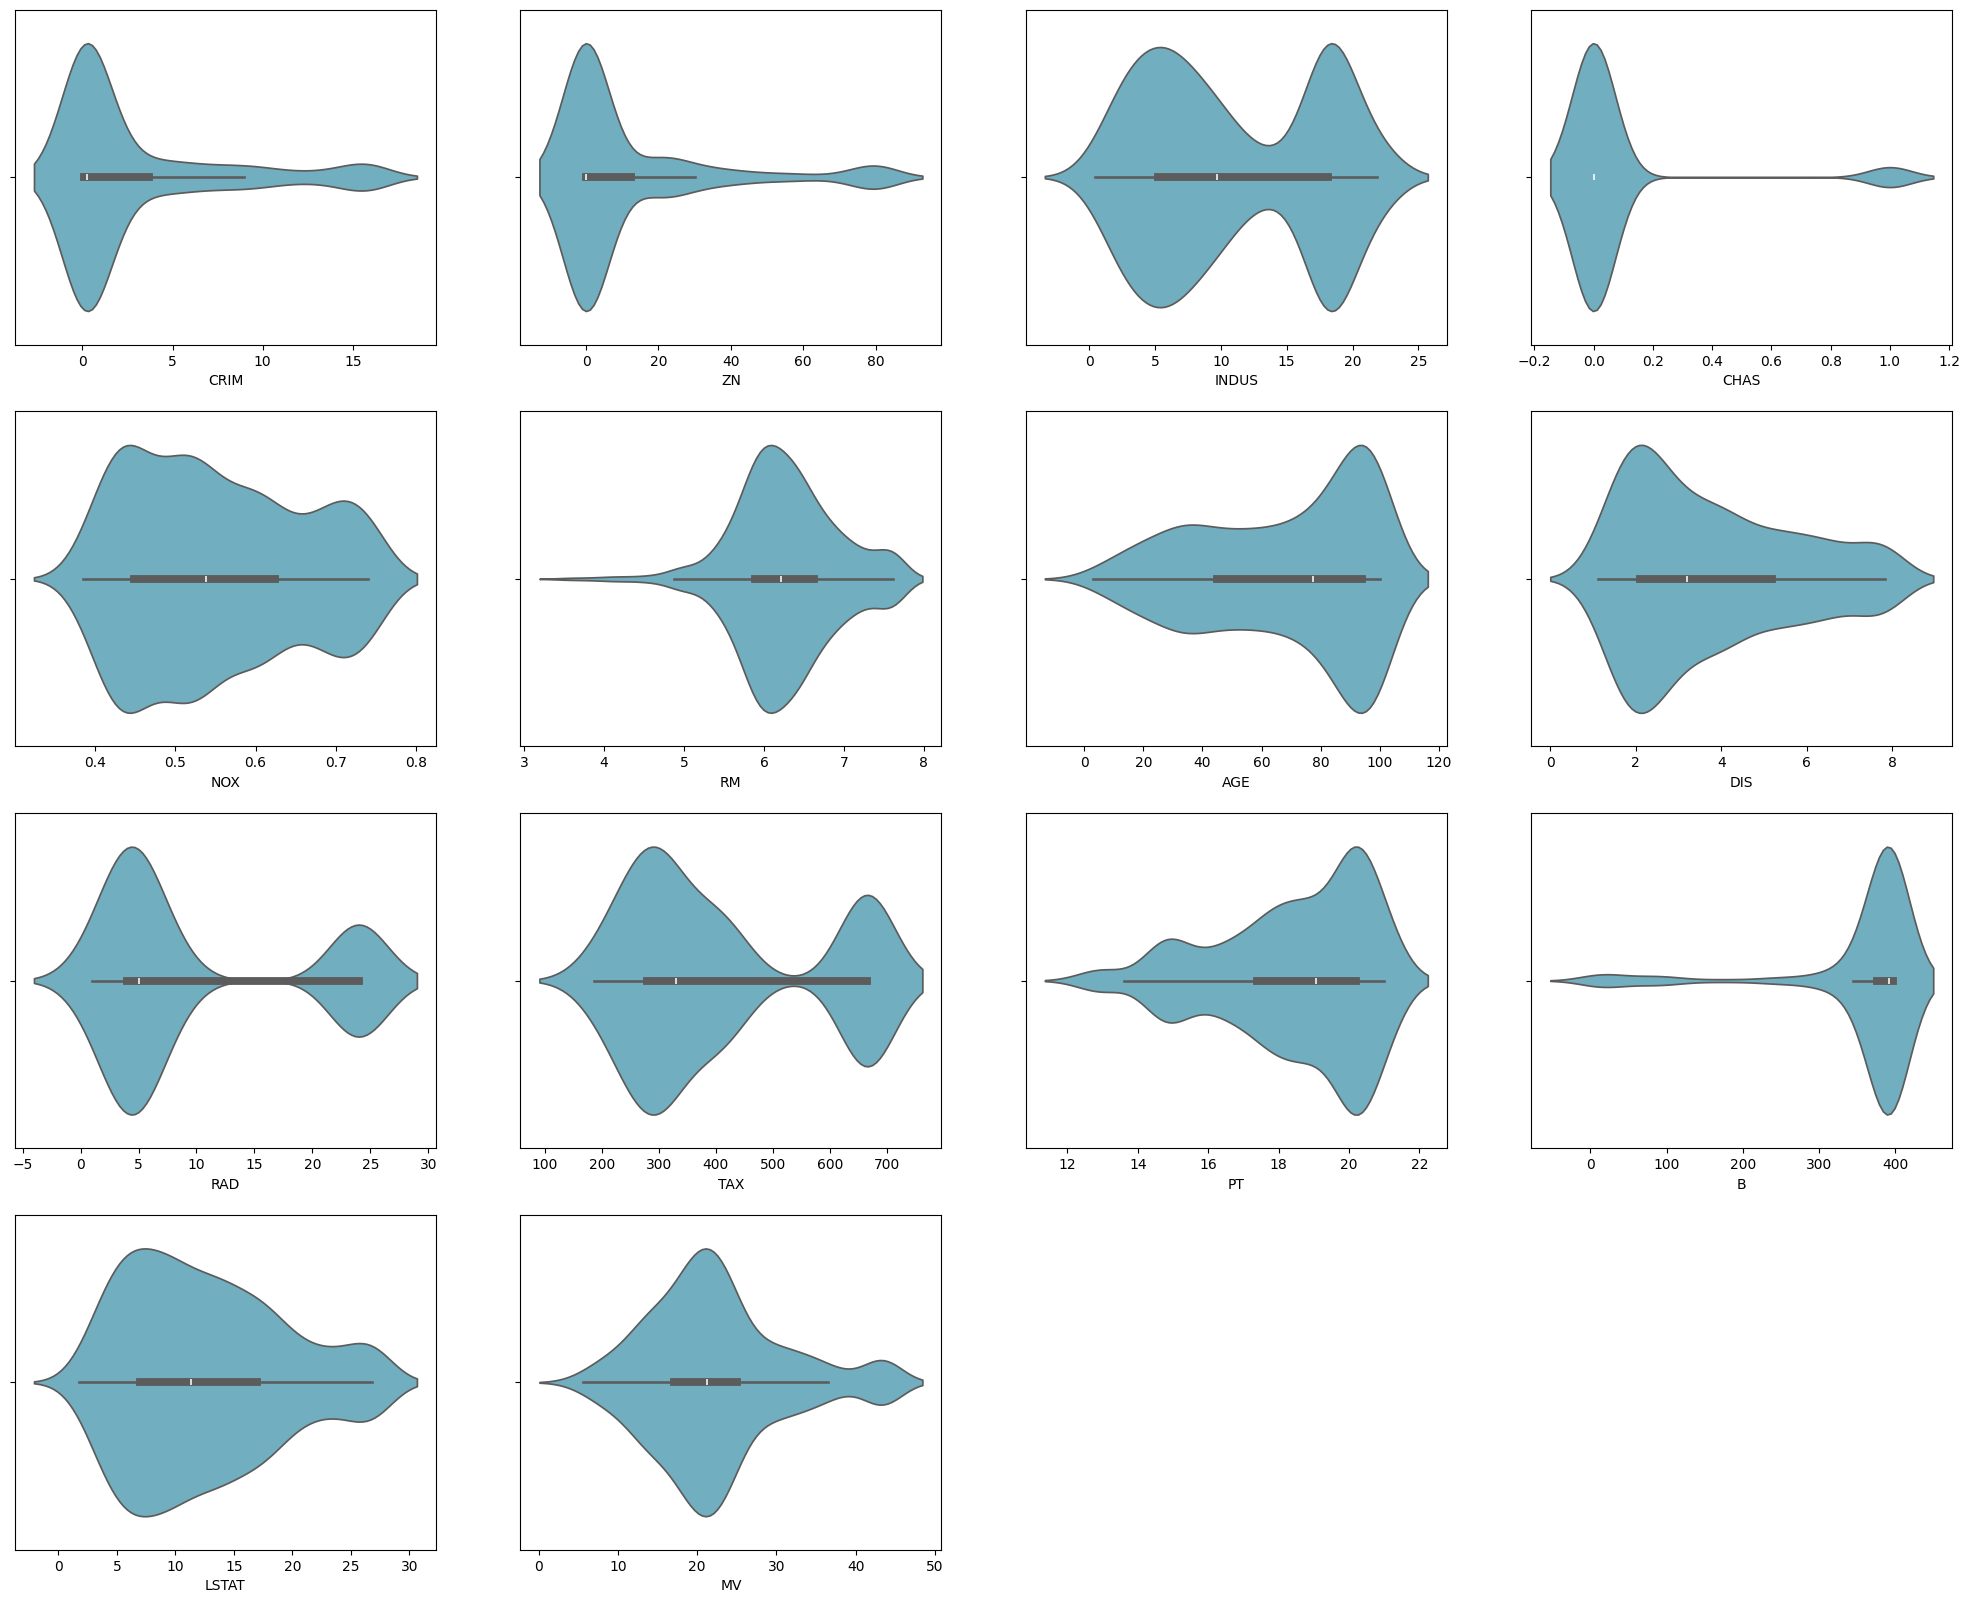

In [31]:
multi_row_plot(sns.violinplot, boston_win)

Add heatmap for an overview of correlation cooeficients

<Axes: >

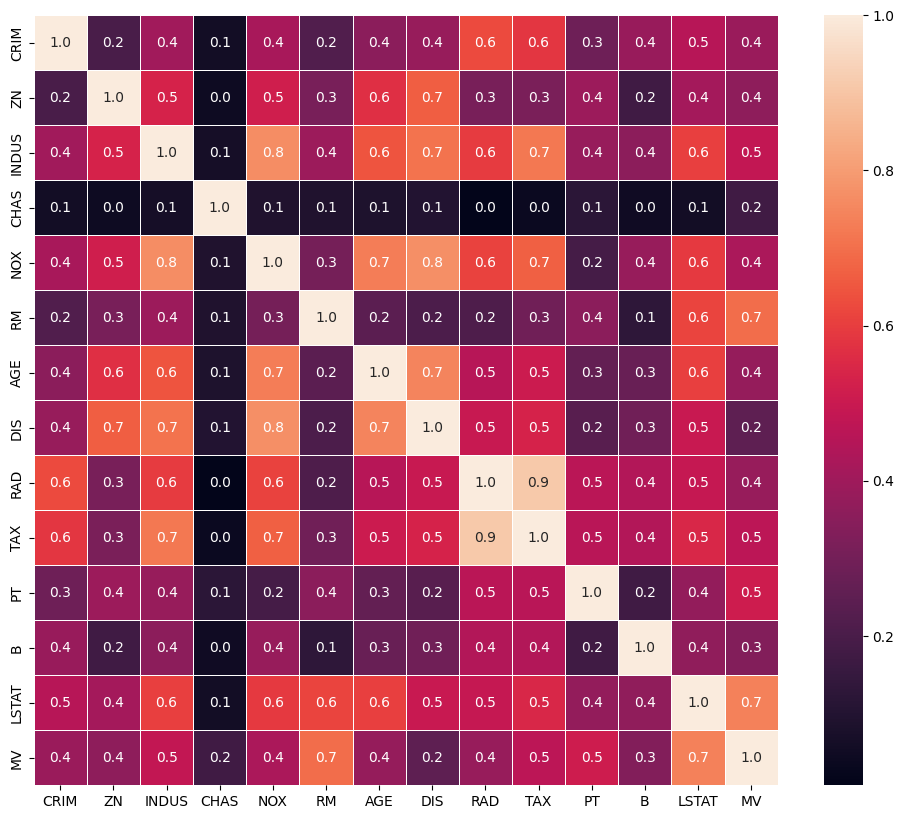

In [17]:
plt.figure(figsize=(12, 10))

corr_matrix = boston_csv.corr().abs()
sns.heatmap(corr_matrix, annot=True, fmt='.1f', linewidth=0.5)

Add pairplot for graph comparison with heatmap

<Figure size 1200x1000 with 0 Axes>

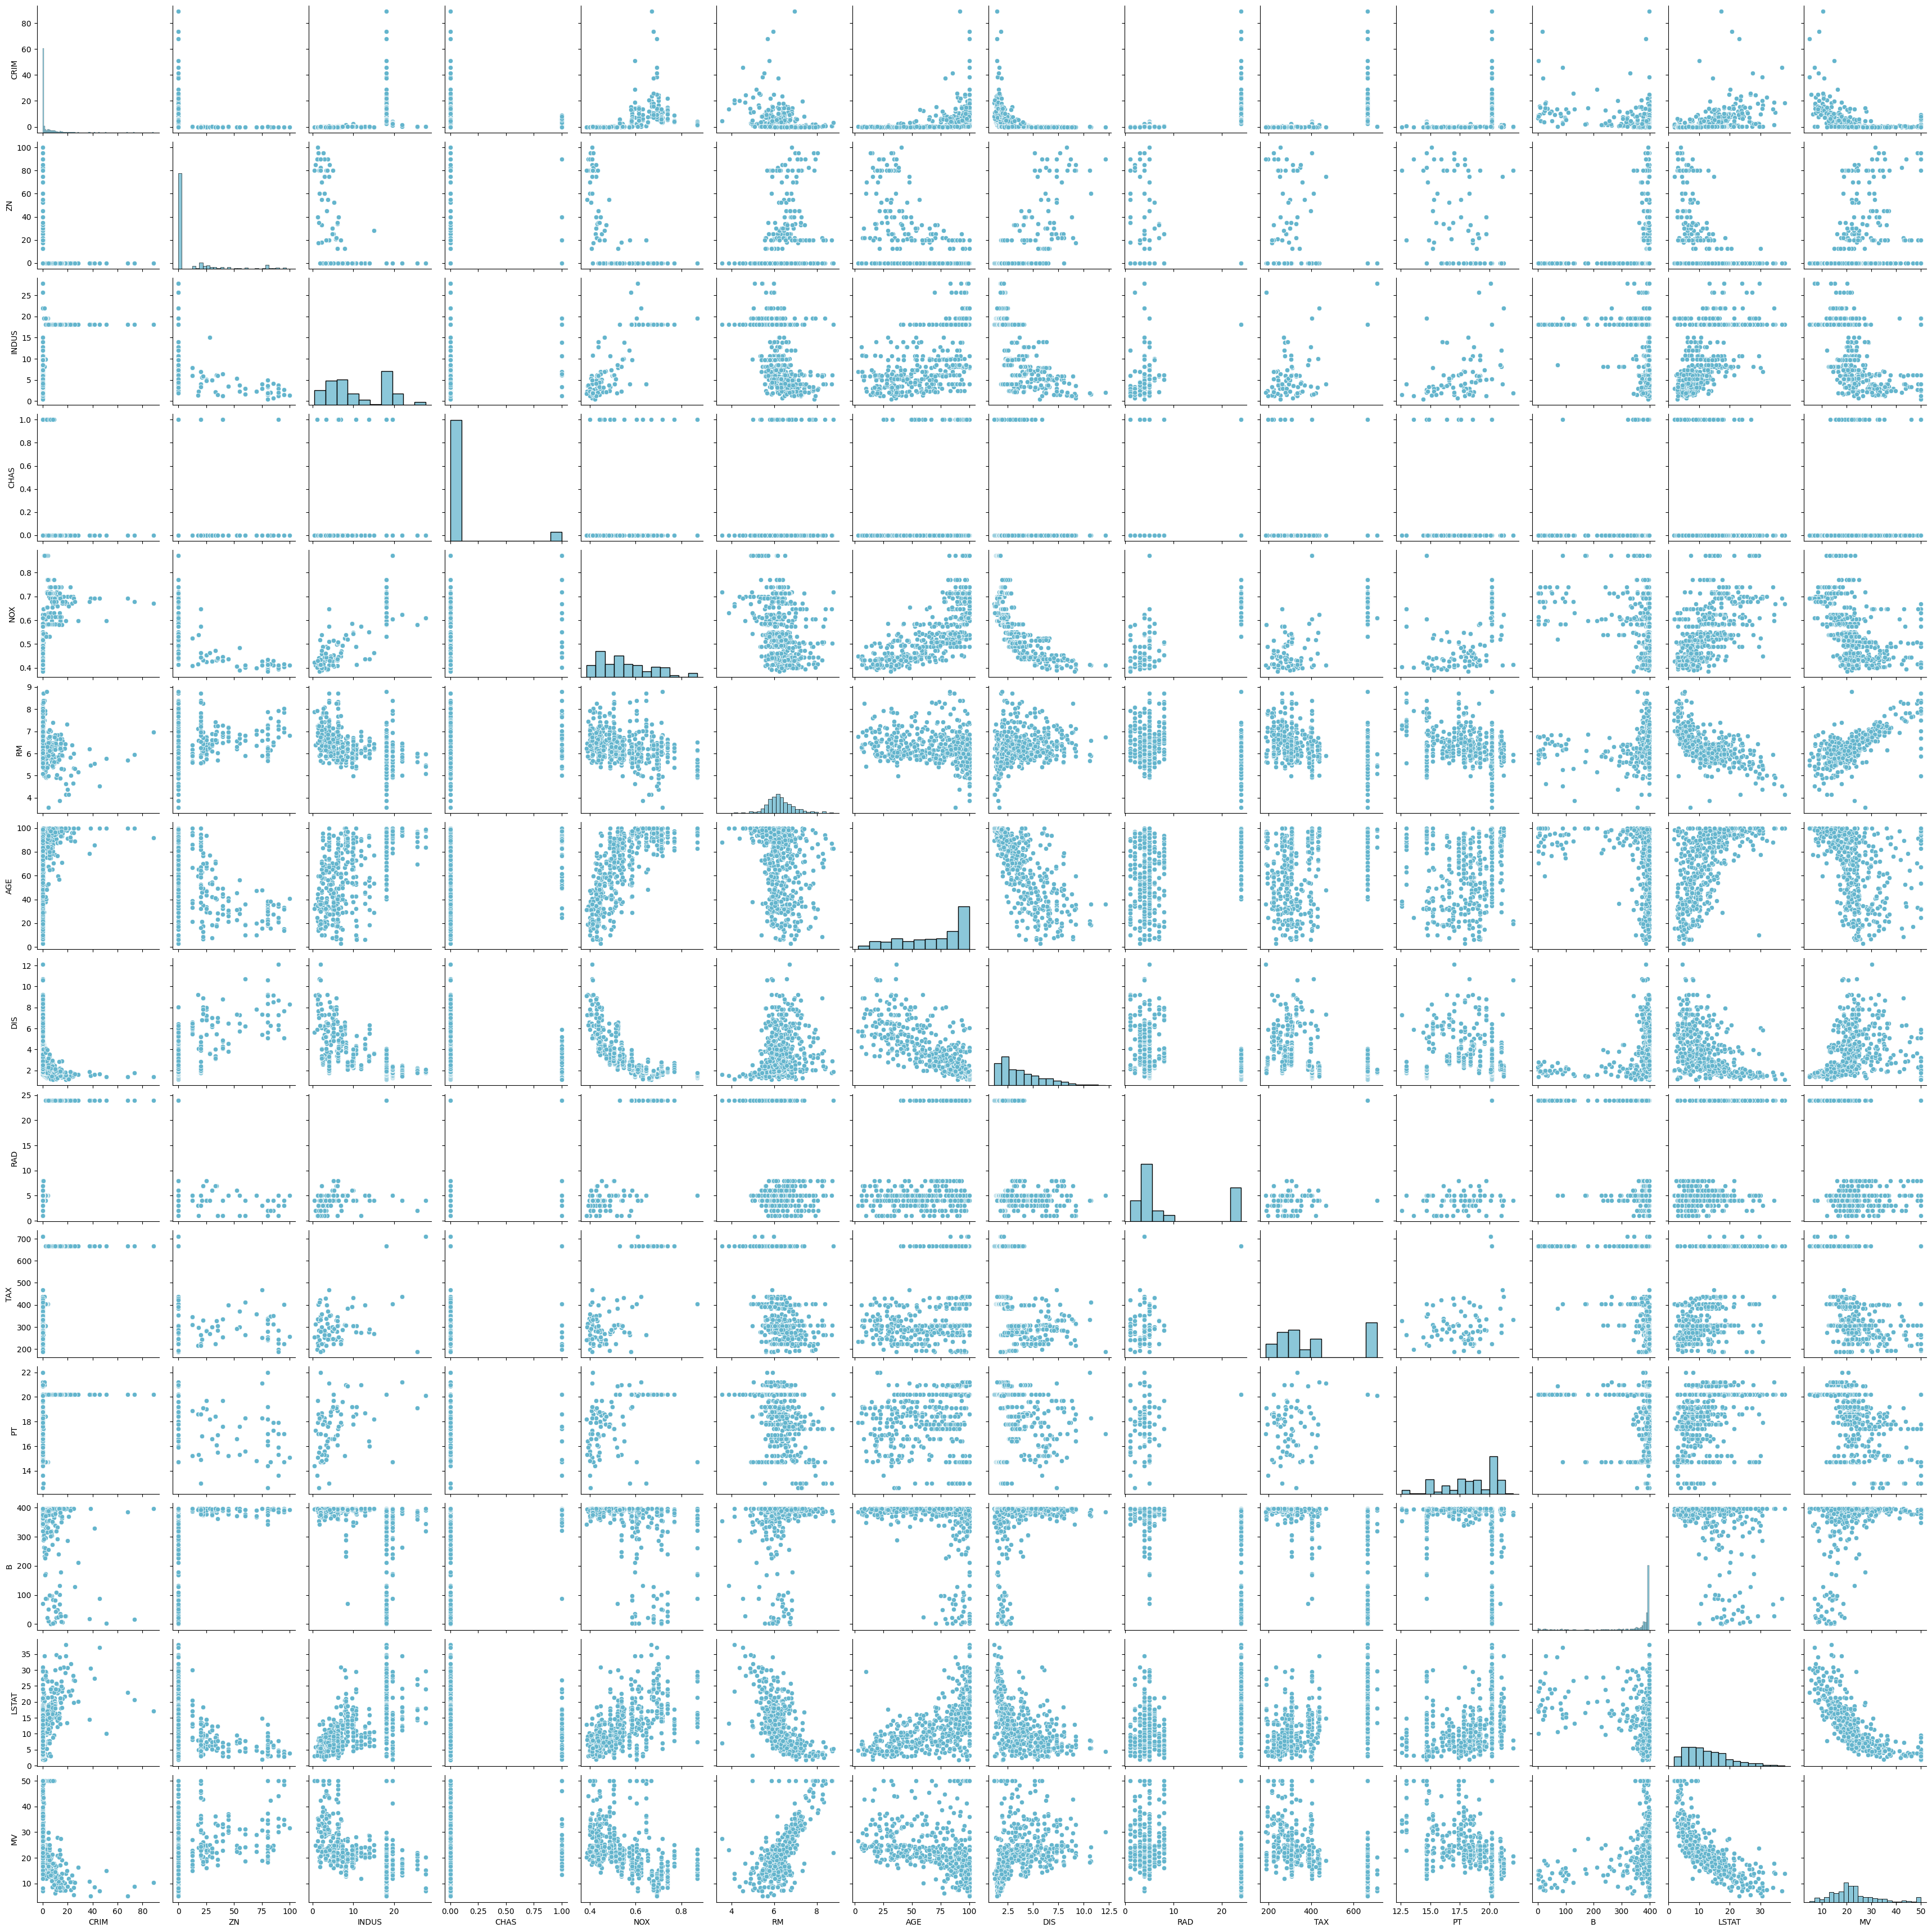

In [32]:
sns.pairplot(boston_csv)

Generate scatter plots for crime comparisons

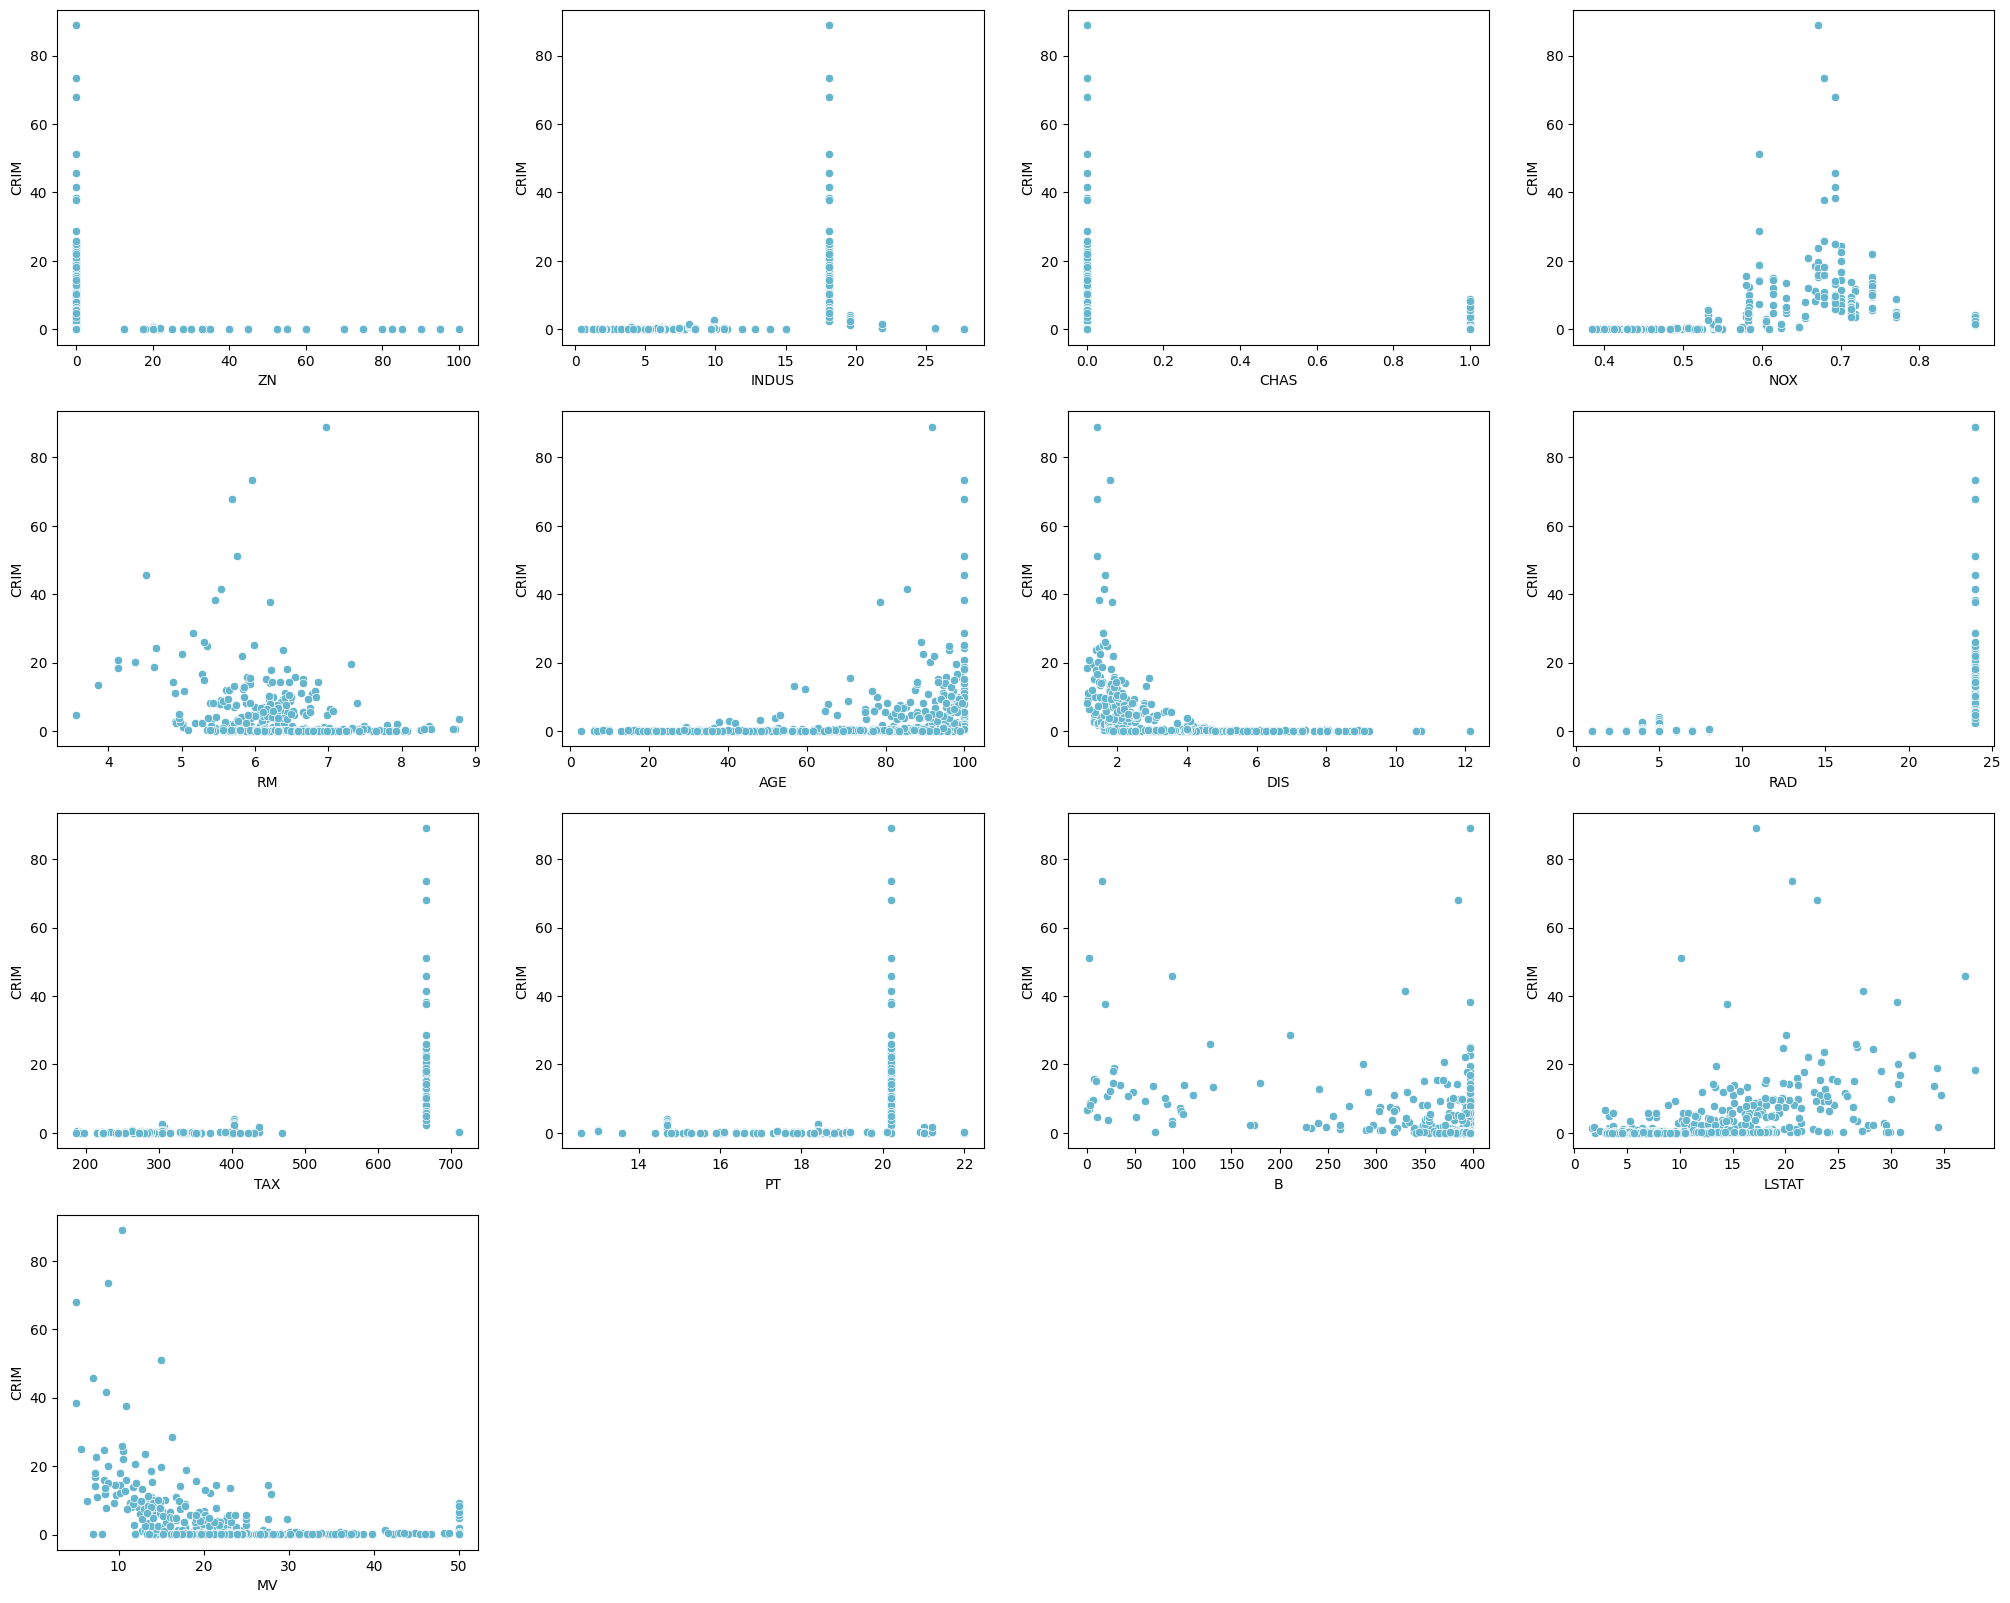

In [11]:
fig_plot, axes = plt.subplots(4, 4, figsize=(25, 20))
axes = axes.flatten()

for i, item in enumerate(boston_csv.columns[1:]):
    sns.scatterplot(data=boston_csv, x=item, y='CRIM', ax=axes[i])

# Remove unused graphs
for j in range(i + 1, len(axes)):
    axes[j].axis('off')